## For Colab

In [ ]:
!pip install yellowbrick

In [ ]:
%cd /content/drive/MyDrive/Intent-Detection/pretrained_embs/ELMo

/content/drive/MyDrive/Intent-Detection/pretrained_embs/ELMo


In [ ]:
!git clone https://github.com/hosjiu1702/ELMoForManyLangs.git

fatal: destination path 'ELMoForManyLangs' already exists and is not an empty directory.


In [ ]:
%cd ELMoForManyLangs/

/content/drive/MyDrive/Intent-Detection/pretrained_embs/ELMo/ELMoForManyLangs


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing elmoformanylangs.egg-info/PKG-INFO
writing dependency_links to elmoformanylangs.egg-info/dependency_links.txt
writing requirements to elmoformanylangs.egg-info/requires.txt
writing top-level names to elmoformanylangs.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'elmoformanylangs.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/__init__.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/__main__.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/biLM.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/dataloader.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
c

In [ ]:
!pwd

/content/drive/MyDrive/Intent-Detection/pretrained_embs/ELMo/ELMoForManyLangs


In [ ]:
%cd /content/drive/MyDrive/Intent-Detection

/content/drive/MyDrive/Intent-Detection


In [ ]:
!pwd
!ls -l
!pip install -r requirements.txt

/content/drive/MyDrive/Intent-Detection
total 168
drwx------ 2 root root   4096 Oct 13 03:25  data
-rw------- 1 root root 162131 Oct 13 03:45 'Intent Classification.ipynb'
drwx------ 3 root root   4096 Oct 13 03:25  pretrained_embs
-rw------- 1 root root     18 Oct 13 03:25  README.md
-rw------- 1 root root     34 Oct 13 03:25  requirements.txt


In [ ]:
!sudo apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,871 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155047 files and directories c

In [ ]:
!git-lfs fetch

Fetching master
Git LFS: (2 of 2 files) 393.35 MB / 393.35 MB


In [ ]:
!git-lfs pull

## Imports

In [ ]:
from collections import namedtuple
from pprint import pprint
from typing import Iterable, List

import pandas as pd
import numpy as np
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import (
    GridSearchCV,
    learning_curve,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.calibration import CalibratedClassifierCV
from elmoformanylangs import Embedder
import matplotlib.pyplot as plt
from yellowbrick.classifier import PrecisionRecallCurve, ClassificationReport

## Text Extraction

In [ ]:
# Load raw data
file_path = "./data/raw/data.xlsx"
df = pd.read_excel(file_path, engine="openpyxl", sheet_name=1)

In [ ]:
df.head()

,fileName,start,end,speaker,sentiment,text,Intent,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,VUQC83EOO969H66VRLO5RMEPC8089Q00_2021-07-16_11...,0.81,1.27,0.0,3.0,a lô,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.86,2.76,0.0,3.0,anh đơn hả anh,Agent_VerifyCustomerName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.62,7.86,0.0,3.0,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction,Agent_CompanyIntroduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.04,34.32,0.0,3.0,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,34.68,35.07,0.0,3.0,anh anh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drops some unnecessary columns
df = df.drop(columns=["fileName", "start", "end", "speaker", "sentiment"])

In [ ]:
df.head()

,text,Intent,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,a lô,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,anh đơn hả anh,Agent_VerifyCustomerName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction,Agent_CompanyIntroduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,anh anh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Dataset = namedtuple("Dataset", ["sentences", "labels"])
dataset = Dataset([], [])

for _, row in df.iterrows():
    # Avoid NaN inside text
    if isinstance(row["text"], str):
        dataset.sentences.append(row["text"])
        labels = []
        for i, val in row.iteritems():
            if i == "text" or isinstance(val, float):
                continue
            labels.append(val)
        dataset.labels.append(labels)

In [ ]:
dataset.sentences[:2]

['a lô', 'anh đơn hả anh']

In [ ]:
dataset.labels[:2]

[[], ['Agent_VerifyCustomerName']]

In [ ]:
len(dataset.sentences), len(dataset.labels)

(8173, 8173)

## Text Cleaning

### Remove duplication

In [ ]:
""" Data Cleaning
"""

# Convert to pandas dataframe from namedtuple
d = dict({
    "sentences": [],
    "labels": []
})
sentences = dataset.sentences
labels = dataset.labels
for sent, lb in zip(sentences, labels):
    # update dict
    d["sentences"].append(sent)
    d["labels"].append(lb)
for idx, item in enumerate(d["labels"]):
    if len(item) == 0:
        d["labels"][idx] = "other"
    else:
        d["labels"][idx] = " | ".join(item)

dataset_df = pd.DataFrame.from_dict(d)

# Take advantage pandas utility for text cleaning
## remove duplicate
print(f"Before drop: {len(dataset_df.index)}", end="\n\n")
dataset_df.drop_duplicates(inplace=True, ignore_index=True)
print(f"After drop: {len(dataset_df.index)}")

Before drop: 8173

After drop: 6167


In [ ]:
dataset_df.head(20)

,sentences,labels
0,a lô,other
1,anh đơn hả anh,Agent_VerifyCustomerName
2,ờ anh em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction | Agent_CompanyIntrodu...
3,a lô cho em hỏi xíu ha là vợ anh chị lép á còn...,Agent_VerifyCustomerName
4,anh anh,other
5,ừm,other
6,anh đưa điện thoại giùm em,other
7,à chị lép hả chị,Agent_Self Introduction
8,à hiện tại hiện thì trong cái đợt dịch đợt dịc...,Agent_CallPurpose
9,cái điện số điện thoại cũ của chị thì em gọi n...,other


## Text Pre-processing

### Tokenization

In [ ]:
for idx, row in dataset_df.iterrows():
    row["sentences"] = ViTokenizer.tokenize(row["sentences"])
dataset_df.head(10)

,sentences,labels
0,a_lô,other
1,anh đơn hả anh,Agent_VerifyCustomerName
2,ờ anh_em là hương nè em gọi đến cho anh từ bên...,Agent_Self Introduction | Agent_CompanyIntrodu...
3,a_lô cho em hỏi xíu ha là vợ anh_chị lép á còn...,Agent_VerifyCustomerName
4,anh anh,other
5,ừm,other
6,anh đưa điện_thoại giùm em,other
7,à chị lép hả chị,Agent_Self Introduction
8,à hiện_tại hiện thì trong cái đợt dịch đợt dịc...,Agent_CallPurpose
9,cái điện số điện_thoại cũ của chị thì em gọi n...,other


## Modeling

### Data Preparation

In [ ]:
""" We transform multi-label classification into
Multiclass classificaiton using OvR (One vs Rest) strategy
"""
X = X = dataset_df["sentences"].tolist()
y = []
items = dataset_df["labels"].tolist()
for item in items:
    labels = item.split(" | ")
    y.append(labels)

# Labels Binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
print("Total samples: %d" % len(X))
print("Train size: %d" % len(X_train))
print("Test size: %d" % len(X_test))

Total samples: 6167
Train size: 4933
Test size: 1234


In [ ]:
pprint(X[10:15])
pprint(X_train[10:15])
pprint(X_test[10:15])

['là hồ_sơ của chị lép á lần lần trước là bên em cũng có hỗ_trợ cho mình mua '
 'trả_góp cái điện_thoại_vi vô ở bạc liêu nè',
 'lần đó là mình góp tốt á chị',
 'nên là lần này à mình được bên em hỗ_trợ á một cái khoản vay tiêu_dùng từ '
 'mười cho tới à',
 'bốn_mươi tám triệu với lãi_suất thấp',
 'dạ']
['chụp hình chứng_minh nhân_dân mặt trước mà sau ảnh khuôn_mặt của anh xong '
 'đến cái mức kí nó sẽ mở cái hợp_đồng ra cho anh coi anh hiểu không anh đọc '
 'anh coi',
 'a không chị giữ máy giúp em để em xác_minh thông_tin của mình hen là tên họ '
 'đầy_đủ của mình là nguyễn thị non hả chị',
 'à bình bình tân thì cũng dịch',
 'ừm à vậy á hả ủa con_con_cái số mới của của',
 'dạ không biết là mình']
['cái lãi_suất của chị rất thấp một triệu có mười bốn ngàn à nếu_như mà lấy '
 'mười triệu thì mỗi tháng góp cho bên em có một triệu không trăm hai mươi tám '
 'ngàn à',
 'dạ sao vậy anh_em thấy cái lãi_suất',
 'nếu mà liên_hệ cái người tên sơn không được thì mới gọi qua em giống như chị '
 'n

In [ ]:
# (samples, labels)
y.shape

(6167, 38)

In [ ]:
### Unique classes
mlb.classes_, len(mlb.classes_)

(array(['Agent_CallPurpose', 'Agent_ChildEducation',
        'Agent_CompanyIntroduction', 'Agent_EMI',
        'Agent_ExplainDocsRequired', 'Agent_ExplainMoneyTranferProcess',
        'Agent_FamilyShopping', 'Agent_GoodClose', 'Agent_Greetings',
        'Agent_HouseFixing', 'Agent_InformCallBack', 'Agent_InsuranceFee',
        'Agent_InterestRate', 'Agent_ListeningSkill', 'Agent_LoanAmount',
        'Agent_LoanDuration', 'Agent_MentioningDisclaimer',
        'Agent_OH_AmountLess', 'Agent_OH_BadExperience',
        'Agent_OH_CustAskForCallingBack', 'Agent_OH_DiscussWithFamily',
        'Agent_OH_HighInterest', 'Agent_OH_HighLoanDuration',
        'Agent_OH_NotRequireInsurance', 'Agent_OH_NotRequireLoan',
        'Agent_RunBusiness', 'Agent_Self Introduction', 'Agent_Summarize',
        'Agent_ThanksClosing', 'Agent_VerifyCustomerName',
        'Client_AmountLess', 'Client_AskForCallingBack',
        'Client_BadExperience', 'Client_DiscussWithFamily',
        'Client_HighInterest', 'Clie

## Feature Extraction

### Count-based vectorizer

#### Tf-idf

In [ ]:
# Tf-idf
tfidf_vect = TfidfVectorizer()
# tfidf_vect = tfidf_vect.fit(X)

### Custom Embeddings

#### Example

In [ ]:
"""
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline


class MyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


X, y = load_iris(return_X_y=True)
pipe = make_pipeline(MyTransformer(),
                     LogisticRegression(solver="saga"))
pipe.fit(X, y)
"""

'\nfrom sklearn.datasets import load_iris\nfrom sklearn.pipeline import make_pipeline\n\n\nclass MyTransformer(BaseEstimator, TransformerMixin):\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        return X\n\n\nX, y = load_iris(return_X_y=True)\npipe = make_pipeline(MyTransformer(),\n                     LogisticRegression(solver="saga"))\npipe.fit(X, y)\n'

#### ELMo Embeddings

In [ ]:
class ELMoEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_dir):
        self.model_dir = model_dir
        self.embedder = Embedder(self.model_dir)

    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Arguments:
            X: Iterable[Iterable] input texts
        """
        if not isinstance(X, List):
            raise ValueError("Your input data should be a list")
        
        if not isinstance(X[0], List):
            X = [X]

        embeddings = self.embedder.sents2elmo(X)
        
        return np.concatenate(embeddings)


texts = [
    ["em đang nơi đâu"],
    ["chúng ta của hiện tại"],
    ["muộn rồi mà sao còn"]
]

model_dir = "pretrained_embs/ELMo/vi/"
elmo = ELMoEmbedder(model_dir)
# outputs = elmo.sents2elmo(texts)
outputs = elmo.transform(texts)
pprint(outputs)

2021-10-13 04:16:19,066 WARNING: Could not find config.  Trying pretrained_embs/ELMo/vi/cnn_50_100_512_4096_sample.json
2021-10-13 04:16:19,069 WARNING: Could not find config.  Trying /content/drive/My Drive/Intent-Detection/pretrained_embs/ELMo/ELMoForManyLangs/elmoformanylangs/configs/cnn_50_100_512_4096_sample.json
2021-10-13 04:16:19,094 INFO: char embedding size: 3920
2021-10-13 04:16:19,568 INFO: word embedding size: 88497
2021-10-13 04:16:26,414 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(88497, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(3920, 50, padding_idx=3917)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, ke

array([[-0.06334513, -0.01504875, -0.09831727, ...,  0.12664728,
        -0.11577673, -0.32729256],
       [-0.03447661,  0.25508228, -0.28790745, ...,  0.2594107 ,
         0.3580422 , -0.04250387],
       [ 0.19482063,  0.33998236, -0.28850168, ...,  0.16124493,
        -0.05382353, -0.41921782]], dtype=float32)


### Model Training

In [ ]:
""" We use Grid Search for doing hyperparameters tuning """

# Cast multi-label problem to multi-class classification one.

# ## setting 1
# pipe1 = Pipeline([
#     ("vect", tfidf_vect),
#     ("clf", OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
# ])
# grid1 = [
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "clf__estimator__max_iter": [50, 100, 1000, 5000],
#         "clf__estimator__C": [0.001, 0.01, 0.1, 1., 10, 100],
#         "clf__estimator__class_weight": ["balanced", None]
#     }
# ]

## setting 2
pipe2 = Pipeline([
    ("vect", tfidf_vect),
    # ("scaler", StandardScaler(with_mean=False)),
    ("clf", OneVsRestClassifier(LinearSVC(), n_jobs=-1))
], memory="cache/tfidf")
grid2 = [
    {
        # "vect__ngram_range": [(1, 2)],
        # "vect__max_df": [0.5],
        # "clf__estimator__class_weight": ["balanced"]
        "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3)],
        "vect__max_df": [0.2, 0.5, 0.75, 1.0],
        "vect__max_features": [25000, 50000, 75000],
        "clf__estimator__C": [0.01, 1, 10, 100],
        "clf__estimator__class_weight": ["balanced", None]
    }
]

# ## setting 3
# pipe3 = Pipeline([
#     ("vect", tfidf_vect),
#     ("clf", OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
# ])
# grid3 = [
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "clf__estimator__alpha": [0.01, 0.1, 1, 10, 100]
#     }
# ]

## setting 4
# pipe4 = Pipeline([
#     ("vect", elmo),
#     ("clf", OneVsRestClassifier(LinearSVC(), n_jobs=-1))
# ])
# grid4 = [
#     {
#         "clf__estimator__alpha": [0.01, 0.1, 1, 10, 100]
#     }
# ]

## Apply grid search
pipes = [pipe2]
grids = [grid2]
best_score = 0.
best_params = None
best_estimator = None
for pipe, grid in zip(pipes, grids):
    gridcv = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring="f1_micro",
                          n_jobs=-1,
                          return_train_score=True)
    gridcv.fit(X_train, y_train)
    if gridcv.best_score_ > best_score:
        best_score = gridcv.best_score_
        best_params = gridcv.best_params_
        best_estimator = gridcv.best_estimator_

## Print some useful infos
print(f"best score: {gridcv.best_score_:.3f}", end="\n\n")
pprint(f"best params: {gridcv.best_params_}")
clf = gridcv.best_estimator_


# Grid params
# grid_params = [
#     # setting 1
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(LogisticRegression(n_jobs=-1))], # Logistic Regression
#         "clf__max_iter": [50, 100, 1000, 5000],
#         "clf__C": [0.001, 0.01, 0.1, 1., 10, 100],
#         "clf__class_weight": ["balanced", None]
#     },

#     # setting 2
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(LinearSVC())], # SVM with linear kernel
#         "clf__C": [0.001, 0.01, 1, 10, 100],
#         "clf__class_weight": ["balanced", None]
#     },

#     # setting 3
#     {
#         "vect__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (1, 3)],
#         "vect__max_df": [0.5, 0.75, 1.0],
#         "vect__min_df": [0.5, 0.75, 1.0],
#         "clf": [OneVsRestClassifier(MultinomialNB())], # Multinomial Naive Bayes
#         "clf__alpha": [0.01, 0.1, 1, 10, 100]
#     }
# ]

# Apply grid search
# grid = GridSearchCV(estimator=pipe,
#                     param_grid=grid_params,
#                     scoring="f1")
# grid.fit(X, y)
# best_estimator = grid.best_estimator_
# print(f"best score: {grid.best_score_:.3f}", end="\n\n")
# pprint(f"best params: {grid.best_params_}")

# clf = Pipeline([
#     ("vect", elmo),
#     # ("scaler", StandardScaler()),
#     ("clf", OneVsRestClassifier(LogisticRegression(random_state=1337, class_weight="balanced"), n_jobs=-1)),
# ], memory="cache/elmo")
# clf.fit(X_train, y_train)

In [ ]:
# Test
texts = [
    ["mười hai tháng thì mỗi tháng anh chỉ cần trả bên em á là à một triệu rồi à một triệu một trăm sáu mươi hai"],
    ["cái lãi suất của chị rất thấp một triệu có mười bốn ngàn à nếu như mà lấy mười triệu thì mỗi tháng góp cho bên em có một triệu không trăm hai mươi tám ngàn à"],
    ["thì ủa thì em ví em ví dụ anh lấy mười triệu một tháng anh đóng có một triệu lẻ mấy chục ngàn à có gì đâu mà ớn"],
    ["thì gốc với lãi tới tháng một tháng là mình đóng là tầm khoảng là hai triệu năm trăm mười chín mười tám ngàn á chị"],
    ["dạ ý là bên công ty bên em mới gửi cái thông báo xuống hỗ trợ khách hàng trong cái dợt dịch này á chị nên em gọi lại cho chị dung ha"],
    ["hà thôi để chi coi lại coi chứ chị chưa có à trong mùa dịch này chị chưa có lấy được"],
    ["nói chung thì năm mươi sáu triệu mà mỗi tháng mình góp bên em á có hai triệu sáu trăm bảy ba ngàn á thì nó"]
]

## preprocessing (here we use tokenization with pyvi)
preprocessed_texts = [ViTokenizer.tokenize(text[0]) for text in texts]
for text in preprocessed_texts:
    print(clf.predict([text]), np.max(clf.predict_proba([text])))

2021-10-13 08:31:46,141 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,178 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,208 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,237 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,266 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,297 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,325 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,354 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,392 INFO: 1 batches, avg len: 3.0


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9994855446750753
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.999462479855063
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9610813804613358
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9130420881927251


2021-10-13 08:31:46,426 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,455 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,487 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,515 INFO: 1 batches, avg len: 3.0
2021-10-13 08:31:46,544 INFO: 1 batches, avg len: 3.0


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9999724985615515
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9994329014869678
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 0.9999625960583886


In [ ]:
vect = best_estimator["vect"]
print("first 10 features in the vocabulary:")
pprint([(k, v) for idx, (k, v) in enumerate(vect.vocabulary_.items())][:10])
print(f"\nNumber of features: {len(vect.get_feature_names_out())}")

In [ ]:
vect.stop_words_

In [ ]:
pd.DataFrame.from_dict(gridcv.cv_results_)

## Visualization

### Learning Curve

2021-10-13 05:05:38,984 WARNING: Could not find config.  Trying pretrained_embs/ELMo/vi/cnn_50_100_512_4096_sample.json
2021-10-13 05:05:38,989 WARNING: Could not find config.  Trying /content/drive/My Drive/Intent-Detection/pretrained_embs/ELMo/ELMoForManyLangs/elmoformanylangs/configs/cnn_50_100_512_4096_sample.json
2021-10-13 05:05:39,015 INFO: char embedding size: 3920
2021-10-13 05:05:39,511 INFO: word embedding size: 88497
2021-10-13 05:05:46,727 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(88497, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(3920, 50, padding_idx=3917)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, ke

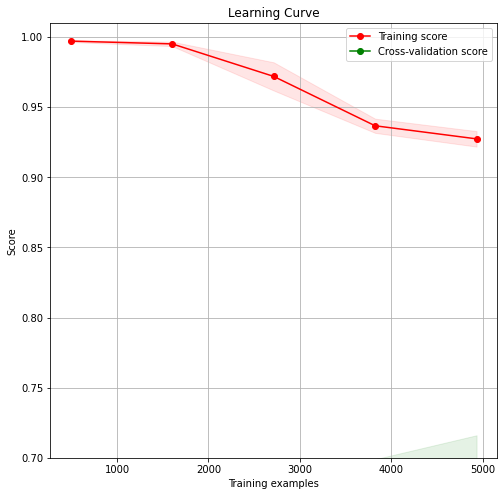

In [ ]:
def plot_learning_curve(estimator, title, X, y, axe=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axe is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axe.set_title(title)

    if ylim is not None:
        axe.set_ylim(*ylim)
    axe.set_xlabel("Training examples")
    axe.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring="f1_micro",
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axe.grid()
    axe.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axe.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axe.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axe.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axe.legend(loc="best")

    return plt

_, axe = plt.subplots(1, 1, figsize=(8, 8))
plot_learning_curve(clf, "Learning Curve", X, y,
                    axe=axe, ylim=(0.0, 1.01), n_jobs=1)
plt.show()

### PR Curve

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


YellowbrickValueError: ignored

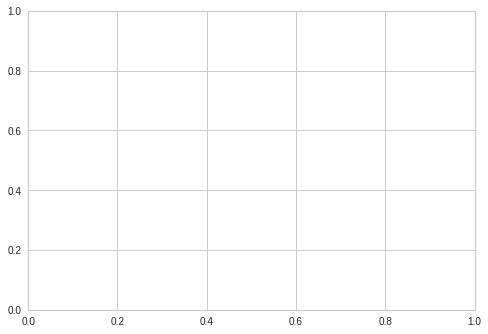

In [ ]:
pr_viz = PrecisionRecallCurve(elmo_svm_clf,
                              per_class=True,
                              cmap="Set1",
                              micro=True)
pr_viz.fit(X_train, y_train)
pr_viz.score(X_test, y_test)
viz.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_game

# Load dataset and encode categorical variables
X, y = load_game()
X = OrdinalEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    RandomForestClassifier(n_estimators=10),
    per_class=True,
    micro=False,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

### Classification Report

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                  precision    recall  f1-score   support

               Agent_CallPurpose       0.69      0.46      0.55        24
            Agent_ChildEducation       0.00      0.00      0.00         0
       Agent_CompanyIntroduction       0.00      0.00      0.00         0
                       Agent_EMI       0.50      0.35      0.41        17
       Agent_ExplainDocsRequired       0.60      0.14      0.23        21
Agent_ExplainMoneyTranferProcess       0.00      0.00      0.00         0
            Agent_FamilyShopping       1.00      0.20      0.33         5
                 Agent_GoodClose       0.00      0.00      0.00         5
                 Agent_Greetings       0.38      0.38      0.38        13
               Agent_HouseFixing       0.00      0.00      0.00         0
            Agent_InformCallBack       0.00      0.00      0.00         5
              Agent_InsuranceFee       0.00      0.00      0.00         2
              Agent_InterestRate     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
!git pull another ma

remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 222 (delta 17), reused 18 (delta 8), pack-reused 174
Receiving objects: 100% (222/222), 126.95 KiB | 3.97 MiB/s, done.
Resolving deltas: 100% (104/104), done.
From https://github.com/hosjiu1702/ELMoForManyLangs
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> another/master
fatal: refusing to merge unrelated histories
